### Importing Libraries and loading dataset

##### Dataset taken from Kaggle: https://www.kaggle.com/code/jijagallery/retail-store-inventory-forecasting/input 
This dataset is used to predict sales quantity with regression models and provide insights to optimize inventory levels, enhance demand prediction and minimize overstocking.

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics # imports entire metrics module from scikit-learn library
from sklearn.metrics import r2_score, mean_squared_error # imports only r2 score and mse from sklearn import metrics

In [3]:
# Create a connection to SQLite database using Python's sqlite3 library
con = sqlite3.connect('test_db.db')

In [4]:
# Reading csv into df
df = pd.read_csv('retail_store_inventory.csv')
print(df.shape)
df.head()

(73100, 15)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,1/1/2022,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,1/1/2022,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,1/1/2022,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,1/1/2022,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,1/1/2022,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [5]:
# Storing the df in the test_db db
df.to_sql(name='rsi',con=con, index=False, if_exists='replace')

73100

In [6]:
# Select the columns from Table
## Execute SQL query and load results into a Dataframe
sql_query = '''
SELECT * 
FROM rsi
'''
pd.read_sql(sql_query,con)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,1/1/2022,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,1/1/2022,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,1/1/2022,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,1/1/2022,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,1/1/2022,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,1/1/2024,S005,P0016,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter
73096,1/1/2024,S005,P0017,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Autumn
73097,1/1/2024,S005,P0018,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter
73098,1/1/2024,S005,P0019,Toys,East,374,264,21,270.52,53.14,20,Rainy,0,55.80,Spring


### Exploratory Data Analysis

In [7]:
# Display the column names
df.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')

In [8]:
# Provides key information about a dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [9]:
# Provides statistical summary of the numerical columns in a DataFrame 
df.describe()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


In [10]:
# Check for any null values
print("Missing Values:")
df.isnull().sum()

Missing Values:


Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

In [11]:
# display frequency count for categorical columns
column_freq_count=df.select_dtypes(include=['object']).columns
for col in column_freq_count:
    print (f"Frequency counts for {col}:")
    print (df[col].value_counts())

Frequency counts for Date:
Date
1/1/2024     100
1/1/2022     100
2/1/2022     100
3/1/2022     100
4/1/2022     100
            ... 
16/1/2022    100
15/1/2022    100
14/1/2022    100
13/1/2022    100
12/1/2022    100
Name: count, Length: 731, dtype: int64
Frequency counts for Store ID:
Store ID
S001    14620
S002    14620
S003    14620
S004    14620
S005    14620
Name: count, dtype: int64
Frequency counts for Product ID:
Product ID
P0001    3655
P0002    3655
P0003    3655
P0004    3655
P0005    3655
P0006    3655
P0007    3655
P0008    3655
P0009    3655
P0010    3655
P0011    3655
P0012    3655
P0013    3655
P0014    3655
P0015    3655
P0016    3655
P0017    3655
P0018    3655
P0019    3655
P0020    3655
Name: count, dtype: int64
Frequency counts for Category:
Category
Furniture      14699
Toys           14643
Clothing       14626
Groceries      14611
Electronics    14521
Name: count, dtype: int64
Frequency counts for Region:
Region
East     18349
South    18297
North    18228
West

In [12]:
print(df['Date'].dtype)

object


In [13]:
# Attempt to convert the 'Date' column to datetime, specifying the format
# dayfirst=True means day comes first (e.g., DD/MM/YYYY)
# errors=coerce means any invalid parsing will be set as Not a Time (NaT)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce') 

# Check for missing dates after conversion
print("Missing dates (NaT):", df['Date'].isnull().sum())

Missing dates (NaT): 0


In [14]:
# Check if the date type has been changed to datetime
print(df['Date'].dtype)

datetime64[ns]


In [15]:
print(df['Date'].describe())

count                            73100
mean     2022-12-31 23:59:59.999999744
min                2022-01-01 00:00:00
25%                2022-07-02 00:00:00
50%                2023-01-01 00:00:00
75%                2023-07-03 00:00:00
max                2024-01-01 00:00:00
Name: Date, dtype: object


In [16]:
print(f"Total number of products: {df['Product ID'].nunique()}")
print(f"Date range: from {df['Date'].min()} to {df['Date'].max()}")

Total number of products: 20
Date range: from 2022-01-01 00:00:00 to 2024-01-01 00:00:00


This is now confirmed that I have daily transaction from 1/1/2022 to 1/1/2024 without missing values/rows in the dataset

In [17]:
# Use the .rename() method to rename column name
# inplace=True means directly renaming the column instead of creating a new column in the dataset. 

df.rename(columns={'Inventory Level':'Stock_level'}, inplace=True)
df.rename(columns={'Units Sold':'Sales_qty'}, inplace=True)
df.rename(columns={'Units Ordered':'Order_qty'}, inplace=True)
df.rename(columns={'Store ID':'Store'}, inplace=True)
df.rename(columns={'Product ID':'Product'}, inplace=True)
df.rename(columns={'Weather Condition':'Weather'}, inplace=True)

In [18]:
# Drop columns that are not relevant for the modeling (i.e. Discount, Competitor Pricing, Demand Forecast & Seasonality)

df.drop(columns=['Discount', 'Competitor Pricing', 'Demand Forecast', 'Holiday/Promotion', 'Seasonality'], inplace=True)

In [19]:
# check the first 5 rows of the dataframe after renaming and dropping columns

df.head()

,Date,Store,Product,Category,Region,Stock_level,Sales_qty,Order_qty,Price,Weather
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,33.50,Rainy
1,2022-01-01,S001,P0002,Toys,South,204,150,66,63.01,Sunny
2,2022-01-01,S001,P0003,Toys,West,102,65,51,27.99,Sunny
3,2022-01-01,S001,P0004,Toys,North,469,61,164,32.72,Cloudy
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,73.64,Sunny


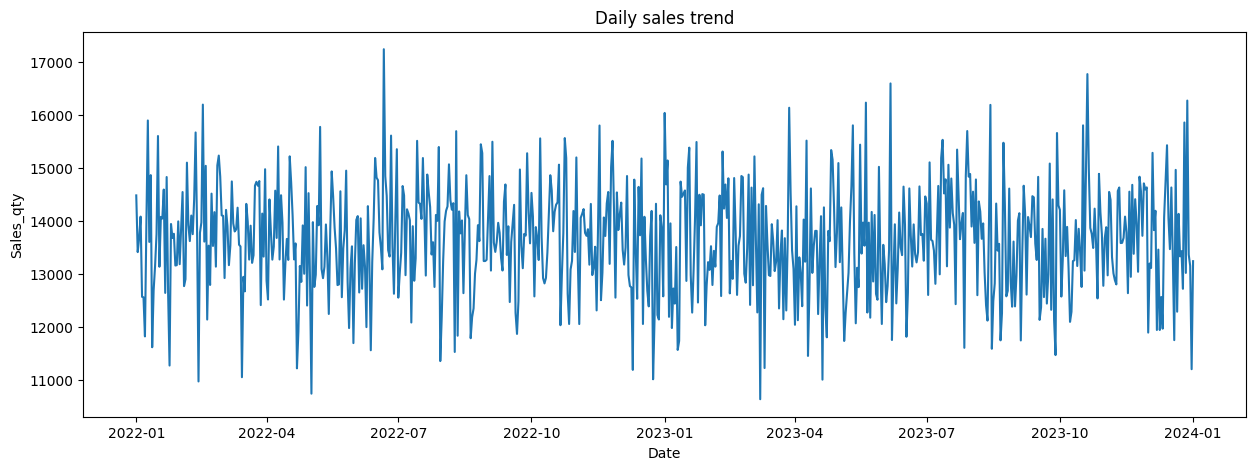

In [20]:
# Visualise the sum of daily sales and review if there is any trend

daily_sales = df.groupby('Date')['Sales_qty'].sum().reset_index()

# Plot daily sales with matplotlib
plt.figure(figsize=(15, 5))
plt.plot(daily_sales['Date'], daily_sales['Sales_qty'])
plt.title('Daily sales trend')
plt.xlabel('Date')
plt.ylabel('Sales_qty')
plt.show()

Overall, the graph show consistent flunctuation in daily sales without any obvious spikes or drastic declines.

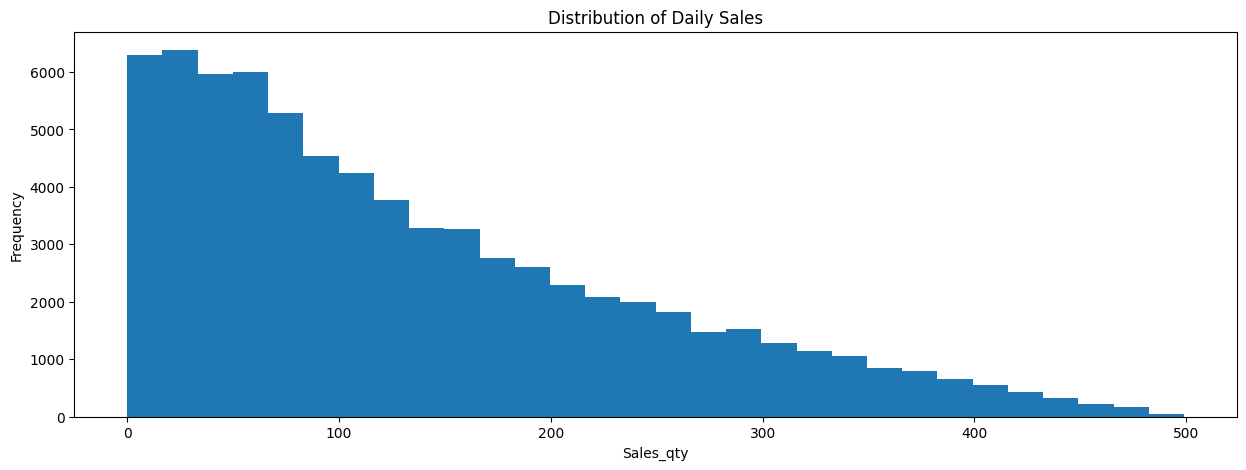

In [21]:
# Visualize the distribution of Sales

plt.figure(figsize=(15, 5))
plt.hist(df['Sales_qty'], bins=30) # bins=30 specifies the number of bins the data is distributed to
plt.title('Distribution of Daily Sales')
plt.xlabel('Sales_qty')
plt.ylabel('Frequency')
plt.show()

Based on the histogram above, the highest frequency/occurrences of product sales is between 0 to 100 quantity daily.

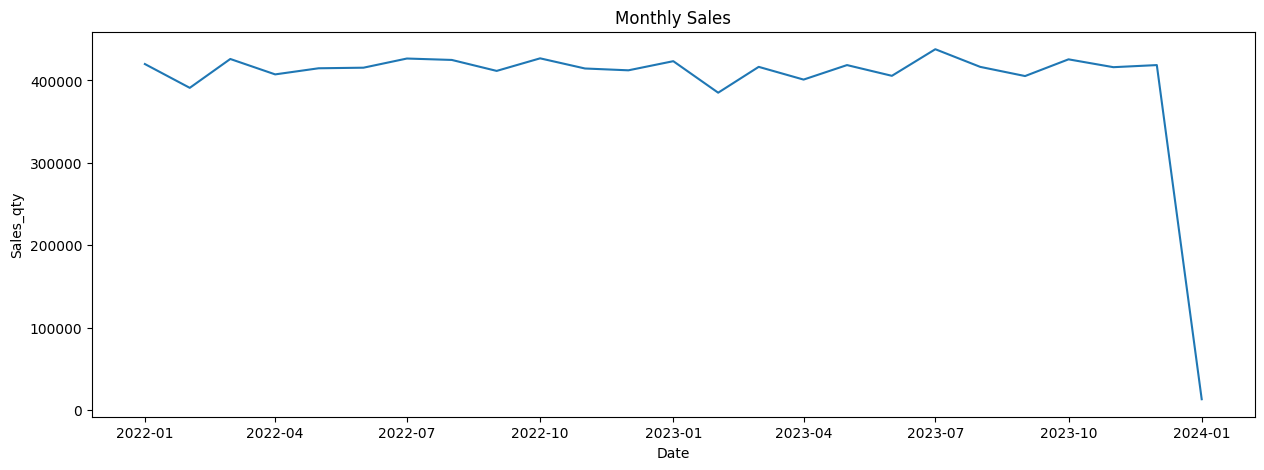

In [22]:
# Monthly Sales trend

monthly_sales = df.groupby(df['Date'].dt.to_period('M'))['Sales_qty'].sum().reset_index()
monthly_sales['Date'] = monthly_sales['Date'].dt.to_timestamp()
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['Date'], monthly_sales['Sales_qty']) 
plt.title('Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales_qty')
plt.show()

The monthly sales trend below reveals a stable sales trend between 300,000 and 400,000 units per month over the two-year period. However, sales suddenly dropped in January 2024 because during January that year, the sales record only has 1st January records while other years, the sales record is based on all the days in the month of January.

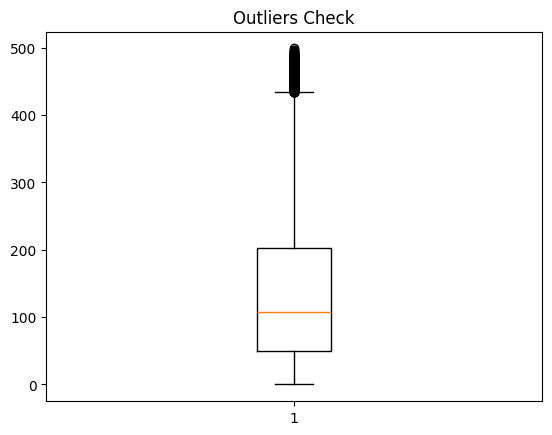

In [23]:
# Check for outliers

plt.boxplot(df['Sales_qty'])
plt.title('Outliers Check')
plt.show()

The box plot visualizes the distribution of sales quantity in the data set. It shows that 100 is the median sales quantity and interquartile range between 50 to 200. The outliers is above 400 which is rare or unusually high demand.

In [24]:
# Top 10 Sales Category & Product

grouping_cols = ['Category','Product']
highest_sales = df.groupby(grouping_cols)['Sales_qty'].max()
top_sales = highest_sales.sort_values(ascending=False)
print(top_sales.head(10))

Category     Product
Furniture    P0018      499
Electronics  P0001      496
Toys         P0012      496
             P0017      495
Groceries    P0008      494
             P0013      494
             P0012      493
Electronics  P0016      492
Groceries    P0007      491
Electronics  P0017      491
Name: Sales_qty, dtype: int64


In [25]:
# Count the number of unique Products in each Category
product_counts = df.groupby('Category')['Product'].nunique().reset_index()

# Rename the columns for clarity
product_counts.columns = ['Category', 'Unique Product Count']

print(product_counts)                             

      Category  Unique Product Count
0     Clothing                    20
1  Electronics                    20
2    Furniture                    20
3    Groceries                    20
4         Toys                    20


In [26]:
# Check the unique Product appear in which category
# Create a boolean crosstab showing Product presence in each Category
# This function creates a cross-tabulation of two(or more) factors

presence_df = pd.crosstab(df['Product'], df['Category']).astype(bool) 
print(presence_df)

Category  Clothing  Electronics  Furniture  Groceries  Toys
Product                                                    
P0001         True         True       True       True  True
P0002         True         True       True       True  True
P0003         True         True       True       True  True
P0004         True         True       True       True  True
P0005         True         True       True       True  True
P0006         True         True       True       True  True
P0007         True         True       True       True  True
P0008         True         True       True       True  True
P0009         True         True       True       True  True
P0010         True         True       True       True  True
P0011         True         True       True       True  True
P0012         True         True       True       True  True
P0013         True         True       True       True  True
P0014         True         True       True       True  True
P0015         True         True       Tr

In [27]:
df.head()

,Date,Store,Product,Category,Region,Stock_level,Sales_qty,Order_qty,Price,Weather
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,33.50,Rainy
1,2022-01-01,S001,P0002,Toys,South,204,150,66,63.01,Sunny
2,2022-01-01,S001,P0003,Toys,West,102,65,51,27.99,Sunny
3,2022-01-01,S001,P0004,Toys,North,469,61,164,32.72,Cloudy
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,73.64,Sunny


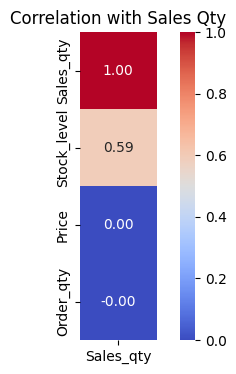

In [28]:
# Select only numeric columns for correlation analysis
numeric_df = df[['Stock_level', 'Sales_qty', 'Order_qty', 'Price']]

# Calculate the correlation matrix for all numeric columns in numeric_df
corr_matrix = numeric_df.corr()

# Filter the corr_matrix with Sales Qty column and sort them in descending order
order_corr = corr_matrix[['Sales_qty']].sort_values(by='Sales_qty', ascending=False)

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(order_corr, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', square=True)
plt.title("Correlation with Sales Qty")
plt.show()

Stock level is correlated to sales qty whereas price and order qty has no correlation with sales qty.
This is because stock level determines whether there is enough to qty to sell.

             Stock_level  Sales_qty  Order_qty     Price
Stock_level     1.000000   0.589995   0.001060  0.009140
Sales_qty       0.589995   1.000000  -0.000930  0.001082
Order_qty       0.001060  -0.000930   1.000000  0.004212
Price           0.009140   0.001082   0.004212  1.000000


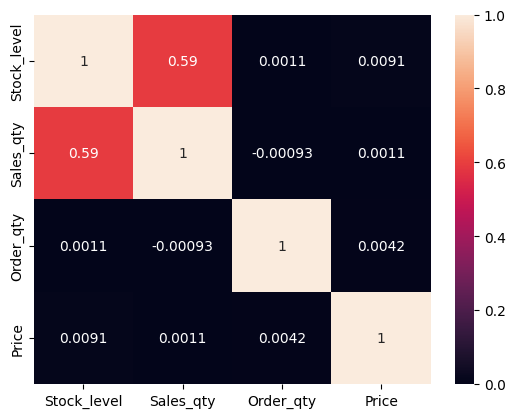

In [29]:
#check for correlation between numerical columns of the dataset

correlations = df[['Stock_level', 'Sales_qty', 'Order_qty', 'Price']].corr()
print(correlations)

# Create the heatmap
sns.heatmap(correlations, annot=True)
plt.show()

The correlation matrix shows the linear relationship between the features in the dataset. Stock level appears to be the highest of all features with moderate positive correlation of 0.59. This means that higher stock levels would suggest higher sales quantities. While the rest of the features are having near zero, which implies no strong linear relationship.

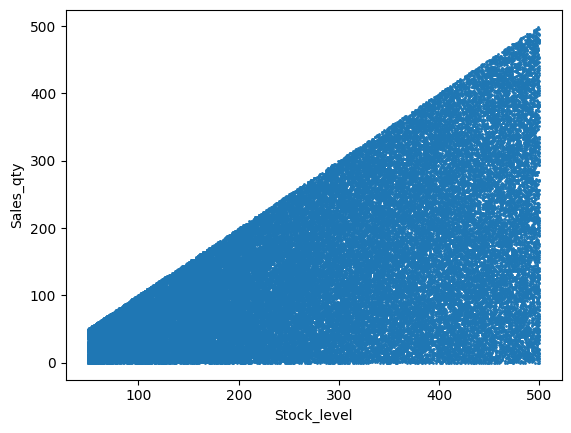

In [30]:
# Plot Sales Qty vs. Stock Level
plt.scatter(df["Stock_level"], df["Sales_qty"], s=1)
plt.xlabel('Stock_level')
plt.ylabel('Sales_qty')
plt.show()

This scatter plot shows how stock level correlates with sales quantity. Since the points form a triangular shape, it suggests that higher stock levels tend to be associated with higher sales quantities. This positive correlation indicates that having more inventory on hand might lead to increased sales, possibly due to greater availability for customers.

## Start Building Models

#### Model 1 - Linear Regression Model

In [31]:
# Determine X and Y
X = df[["Stock_level"]]
y = df["Sales_qty"]

In [32]:
# Split the data into training and testing sets  (75% TRAIN, 25% TEST)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [33]:
# Instantiate and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
# Train score (only for train data)
lr.score(X_train, y_train)

0.3481047433493619

In [35]:
# Test score (only for Test data)
lr.score(X_test, y_test)

0.34803338462810807

#### Model 2 - Random Forest Model

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
# Determine X and Y
X = df[["Stock_level"]]
y = df["Sales_qty"]

In [38]:
# Split the data into training and testing sets  (75% TRAIN, 25% TEST)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [39]:
# Instantiate and fit the model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [40]:
# Train score 
rf.score(X_train, y_train)

0.35395736998327443

In [41]:
# Test score 
rf.score(X_test, y_test)

0.34265493032531713

__Linear Regression R²: 34.8%__
This indicates that LR model explains approximately 34.8% of the variance in sales qty based on stock level.

__Random Forest R²: 34.28%__
This indicates that RF model also explains approximated 34.2% of the variance in sales qty.

To delve deeper, let's improve the prediction by adding new features to the dataset to see if it improves the modeling. 

#### Model 3 - Add in new features (Category & Order_qty) to **Linear regression model**

In [42]:
# Step 1: One-Hot Encode the Categorical Variables
df_encoded = pd.get_dummies(df, columns=['Category'], drop_first=True)

# Step 2: Define Features and Target Variable
# Include the relevant numerical features along with the one-hot encoded features
feature_cols = ['Stock_level', 'Order_qty'] + [col for col in df_encoded.columns if col.startswith('Category_')]

In [43]:
# Include the relevant numerical features along with the one-hot encoded features
X = df_encoded[feature_cols]
y = df_encoded['Sales_qty']

In [44]:
# Create Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [45]:
#Instantiate and Fit the Linear Regression Model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [46]:
# Train score (only for train data)
linreg.score(X_train, y_train)

0.3481379387364444

In [47]:
# Test score (only for Test data)
linreg.score(X_test, y_test)

0.3479493462182527

R² remains the same at 34.8 when more features were added to the linear regression model. It shows these new features might not be strong predictors of sales qty.

In Random forest modeling, train data did well but perform bad on the test data too. 

In conclusion, linear regression (Model 1 with just stock level) performs better than random forest regression in this case. 
The model will perform better if there are more strong and meaningful features to predict sales qty. 

In this case, the strongest feature to sales qty is stock level with a correlation of 0.59 to sales qty, hence can deduce that stock level directly impacts the sales figures positively. As such, there needs to be enough stocks based on previous purchases for sales to be consistent.